In [1]:
import os
import sys
import logging
import datetime
import json
import time
import numpy as np
from tqdm import tqdm

from transformers import TrainingArguments, Trainer

import torch
from torch.utils.data import DataLoader
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

from dataset_config import COCO_dataset_config
from custom_datasets.nice_dataset import NICETrainDataset, NICETestDataset
from utils import get_device_map

%matplotlib inline

os.environ["TOKENIZERS_PARALLELISM"] = "false"

/home/kjh/anaconda3/envs/my_env_NICE/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# devices = [0]
devices = [1, 5, 6, 7]
start_device = 'cuda:' + str(devices[0])

### Logging

In [3]:
# train result save dir name
results_dir = '../results'
result_dirname = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
result_dir_fullpath = os.path.join(results_dir, result_dirname)
os.makedirs(result_dir_fullpath, exist_ok=True)

In [4]:
logging.basicConfig(
    format="%(asctime)s - %(levelname)s: %(message)s",
    level=logging.INFO,
    datefmt="%I:%M:%S",
    handlers=[
        logging.FileHandler(os.path.join(result_dir_fullpath, 'train.log')),
        logging.StreamHandler(sys.stdout),
    ])

In [5]:
# tensorboard
writer = SummaryWriter(os.path.join('../runs', result_dirname))

### Configuration

In [6]:
# blip2 설정 참고하기
# https://github.com/salesforce/LAVIS/blob/main/lavis/projects/blip2/train/caption_coco_ft.yaml

checkpoint = "Salesforce/blip2-flan-t5-xl"
# cache_dir = "/mnt/nas2/kjh/huggingface_cache"
cache_dir = "../caches"
cache_pretrained_files_dir = os.path.join(cache_dir, "pretrained_files")
cache_dataset_dir = os.path.join(cache_dir, "datasets")
cfg_path = "../configs/caption_coco_ft.yaml"

dtype = torch.float32
batch_size=4
num_workers=4
max_length=50   # val에서 최대 토큰 개수가 44개

model_name = checkpoint.split("/")[1]

In [7]:
from omegaconf import OmegaConf, DictConfig

config = OmegaConf.load(cfg_path)

def dict_to_str_recursive(input_dict, depth=0):
    result_str = ''
    indent_str = '&nbsp;&nbsp;&nbsp;&nbsp;' * depth
    for key in input_dict:
        if type(input_dict[key]) in [dict, DictConfig]:
            value_str = dict_to_str_recursive(input_dict[key], depth + 1)
            result_str += indent_str + str(key) + ':  \n' + value_str + '  \n'
        else:
            value_str = str(input_dict[key])
            result_str += indent_str + str(key) + ': ' + value_str + '  \n'
    return result_str

config_str = dict_to_str_recursive(config)
writer.add_text('configs', config_str)

### Processor
##### image-processor + tokenizer

In [8]:
from transformers import Blip2Processor

processor = Blip2Processor.from_pretrained(
    checkpoint,
    cache_dir=cache_pretrained_files_dir,
)

### Dataset

In [9]:
def custom_collate(batch):
    images = []
    captions = []
    attention_masks = []
    for sample in batch:
        images.append(sample[0])
        captions.append(torch.LongTensor(sample[1]))
        attention_masks.append(torch.Tensor(sample[2]))
    return torch.stack(images).contiguous(), torch.stack(captions).contiguous(), torch.stack(attention_masks).contiguous()

In [10]:
from dataset_config import nice_dataset_config
from torch.utils.data import DataLoader

train_ds = NICETrainDataset(
    img_dir=nice_dataset_config['val_image_folder'],
    ann_file=nice_dataset_config['val_caption_csv'],
    vis_processor=processor.image_processor,
    tokenizer=processor.tokenizer,
    max_length=max_length
)

train_dataloader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=True,
    collate_fn=custom_collate   # 이미지는 [batch_size, ...] 크기로 잘 가져오는데 text는 [max_token_length, batch_size] 이렇게 가져오는 문제가 있어서 custom_collate 구현
)

In [11]:
# prompt_tokens를 model의 input_ids로 넣고 있다.
prompt_tokens = processor.tokenizer(
    "a photo of", padding='max_length', max_length=max_length, return_tensors='pt'
)

### Plot Images

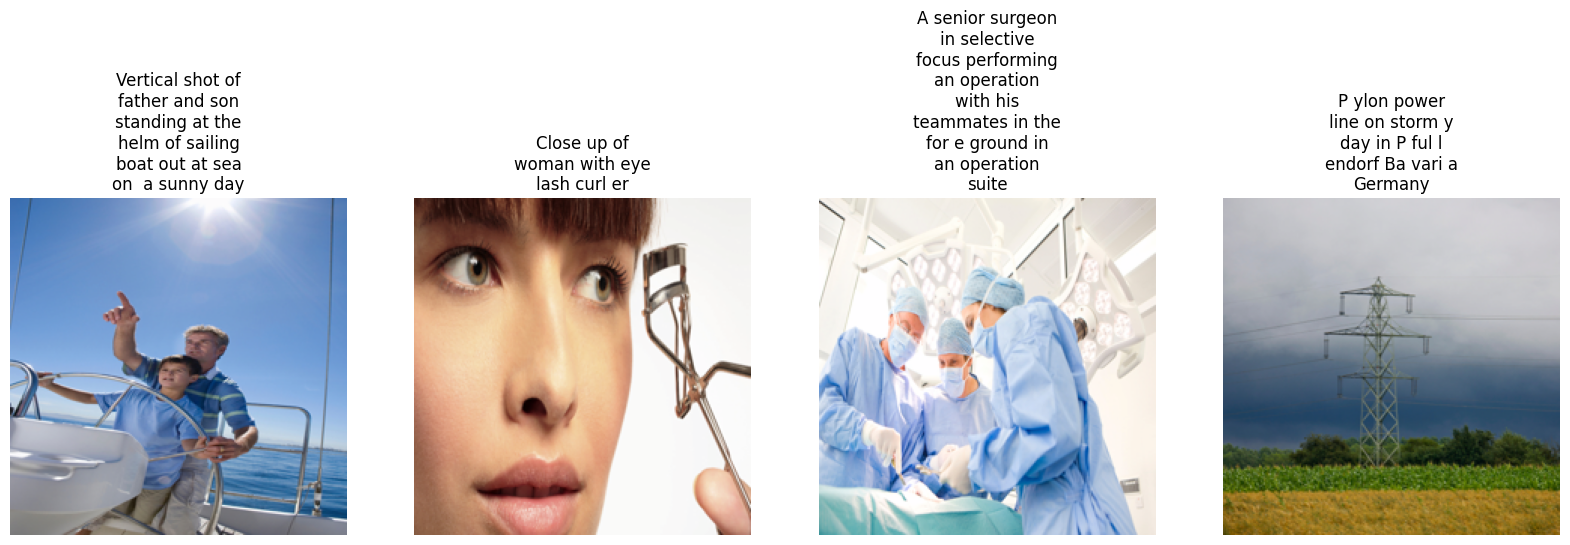

In [12]:
from utils import denormalize_image, plot_images

num_samples = min(5, batch_size)
pixel_values, input_ids, attention_masks = next(iter(train_dataloader))

sample_images = []
sample_captions = []
for i in range(num_samples):
    sample_image = np.array(pixel_values[i])
    sample_image = denormalize_image(sample_image, processor.image_processor.image_mean, processor.image_processor.image_std)
    sample_images.append(sample_image)
    
    sample_caption = ' '.join(processor.batch_decode(input_ids[i], skip_special_tokens=True))
    sample_captions.append(sample_caption)

plot_images(sample_images, sample_captions wrap_width=20)

### Model

In [13]:
from transformers import Blip2ForConditionalGeneration

device_map = get_device_map(checkpoint, devices)

model = Blip2ForConditionalGeneration.from_pretrained(
    checkpoint,
    cache_dir=cache_pretrained_files_dir,
    torch_dtype=dtype,
    device_map=device_map,
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:22<00:00, 11.14s/it]


In [14]:
block_list = [
    model.vision_model,
    model.qformer,
    model.language_projection,
    model.language_model,
]

# freeze 할 블록들
freeze_list = [
    # model.vision_model,
    # model.qformer,
    # model.language_projection,
    model.language_model,
]

for freeze_block in freeze_list:
    for name, param in freeze_block.named_parameters():
        param.requires_grad = False
    freeze_block = freeze_block.eval()

for block in block_list:
    if block not in freeze_list:
        for name, param in block.named_parameters():
            param.requires_grad = True
    block = block.train()

### Optimizer & Scheduler

In [15]:
"""
 Copyright (c) 2022, salesforce.com, inc.
 All rights reserved.
 SPDX-License-Identifier: BSD-3-Clause
 For full license text, see the LICENSE file in the repo root or https://opensource.org/licenses/BSD-3-Clause
"""

num_parameters = 0
p_wd, p_non_wd = [], []
for n, p in model.named_parameters():
    if not p.requires_grad:
        continue  # frozen weights
    if p.ndim < 2 or "bias" in n or "ln" in n or "bn" in n:
        p_non_wd.append(p)
    else:
        p_wd.append(p)
    num_parameters += p.data.nelement()

optim_params = [
    {
        "params": p_wd,
        "weight_decay": float(config.run.weight_decay),
    },
    {"params": p_non_wd, "weight_decay": 0},
]
beta2 = config.run.get("beta2", 0.999)
optimizer = torch.optim.AdamW(
    optim_params,
    lr=float(config.run.init_lr),
    weight_decay=float(config.run.weight_decay),
    betas=(0.9, beta2),
)

In [16]:
from scheduler import LinearWarmupCosineLRScheduler

lr_sched_cls = LinearWarmupCosineLRScheduler

max_epoch = config.run.max_epoch
min_lr = config.run.min_lr
init_lr = config.run.init_lr

# optional parameters
decay_rate = config.run.get("lr_decay_rate", None)
warmup_start_lr = config.run.get("warmup_lr", -1)
warmup_steps = config.run.get("warmup_steps", 0)

lr_scheduler = lr_sched_cls(
    optimizer=optimizer,
    max_epoch=max_epoch,
    min_lr=min_lr,
    init_lr=init_lr,
    decay_rate=decay_rate,
    warmup_start_lr=warmup_start_lr,
    warmup_steps=warmup_steps,
)

### Training

In [17]:
def train(train_dataloader):
    start_time = time.time()
    iters_per_epoch = len(train_dataloader)

    logging.info("Start training")
    for epoch in tqdm(range(0, max_epoch), desc='epochs', position=0):
        inner_epoch = epoch

        epoch_loss = 0.0
        for i, (pixel_values, input_ids, attention_masks) in enumerate(tqdm(train_dataloader, desc='iters', position=1)):
            pixel_values = pixel_values.to(start_device, dtype)

            lr_scheduler.step(cur_epoch=inner_epoch, cur_step=i)
            # input_ids에 "a photo of " 프롬프트가 들어가야 하나?
            # decoder_input_ids는 -> labels 설정하니까 안넣어도 됨

            model_output = model(pixel_values, input_ids=prompt_tokens['input_ids'].repeat(batch_size, 1), labels=input_ids, attention_mask=attention_masks)
            loss = model_output.loss
            epoch_loss += loss.item()

            loss.backward()

            optimizer.step()
            optimizer.zero_grad()
            
            del model_output

        epoch_loss /= iters_per_epoch
        logging.info(f'{epoch} epoch loss: {epoch_loss:.6f}')
        writer.add_scalar('loss', epoch_loss, epoch)

    total_time = time.time() - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))
    logging.info("Training time {}".format(total_time_str))


In [18]:
train(train_dataloader)

05:05:05 - INFO: Start training


iters: 100%|██████████| 1250/1250 [24:28<00:00,  1.17s/it]

05:29:33 - INFO: 0 epoch loss: 12.580490



iters: 100%|██████████| 1250/1250 [24:21<00:00,  1.17s/it]

05:53:55 - INFO: 1 epoch loss: 0.113774



iters: 100%|██████████| 1250/1250 [24:20<00:00,  1.17s/it]

06:18:15 - INFO: 2 epoch loss: 0.040944



iters: 100%|██████████| 1250/1250 [24:23<00:00,  1.17s/it]

06:42:38 - INFO: 3 epoch loss: 0.018366



iters: 100%|██████████| 1250/1250 [24:26<00:00,  1.17s/it]

07:07:05 - INFO: 4 epoch loss: 0.010763



epochs: 100%|██████████| 5/5 [2:01:59<00:00, 1463.95s/it]

07:07:05 - INFO: Training time 2:01:59


In [19]:
model_save_dir = '../saved_models'
os.makedirs(model_save_dir, exist_ok=True)
model_save_path = os.path.join(model_save_dir, f'{model_name}_{max_epoch}epochs')
model.save_pretrained(model_save_path)

--- Logging error ---
Traceback (most recent call last):
  File "/home/kjh/anaconda3/envs/my_env_NICE/lib/python3.9/logging/__init__.py", line 1083, in emit
    msg = self.format(record)
  File "/home/kjh/anaconda3/envs/my_env_NICE/lib/python3.9/logging/__init__.py", line 927, in format
    return fmt.format(record)
  File "/home/kjh/anaconda3/envs/my_env_NICE/lib/python3.9/logging/__init__.py", line 663, in format
    record.message = record.getMessage()
  File "/home/kjh/anaconda3/envs/my_env_NICE/lib/python3.9/logging/__init__.py", line 367, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/home/kjh/anaconda3/envs/my_env_NICE/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/kjh/anaconda3/envs/my_env_NICE/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/kjh/anaconda3/envs/my_env_NICE/lib/python3.9/site

biking in the woods


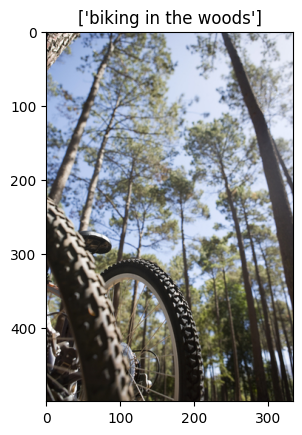

In [25]:
from PIL import Image
from utils import show_image_caption

image = '../datasets/cvpr-nice-val/val/215268662.jpg'
# caption_gt = 'Bicycles leaning against tree in wood Close up low angle view'
raw_image = Image.open(image).convert('RGB')

inputs = processor(raw_image, text="a picture of ", return_tensors="pt").to(start_device, dtype)

generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

show_image_caption(raw_image, [generated_text], show_fig=True)